In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph, BO_graph_local_loss

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *



/home/chenzhil/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from Models.ModelMNIST import ModelMNIST
from mnist.MNISTLoader import *
from helper import *

ground_truth_param_mnist = {"Blackbox7": np.array([0.8,0.8]), 6 : np.array([0.7, 0.9, 0.5]), 2: np.array([0.5, -.7]), 12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5])}


In [ ]:
data_generation_seed = 99
bb_component_noise = -2.0
grad_descent_starting_seed = 800
dg_nn = create_mnist_system(ground_truth_param_mnist, noise=bb_component_noise, seed=data_generation_seed)
nx.draw_networkx(dg_nn)
plt.show()

In [10]:
local_mnist_nine,system_mnist_nine = generate_data_loader(num_datapts=100,batch_size=100, start_idx=1000, label_int=7)
component=ModelMNIST(local_train_loader=local_mnist_nine, system_train_loader=system_mnist_nine, output_size=2)

In [80]:
model = ModelLogistic()

X = np.random.uniform(0, 5, (10, 3))
y = np.random.randint(0,2,(10,1))
model.X = torch.Tensor(X)
model.y = torch.Tensor(y)

print(model.get_local_loss())
model.do_one_descent_on_local()
print(model.get_local_loss())

tensor(0.7938, grad_fn=<AddBackward0>)
tensor(0.7898, grad_fn=<AddBackward0>)


In [61]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
nx.draw_networkx(dg_nn,node_size=500)

final system loss:  tensor(0.1253, dtype=torch.float64)


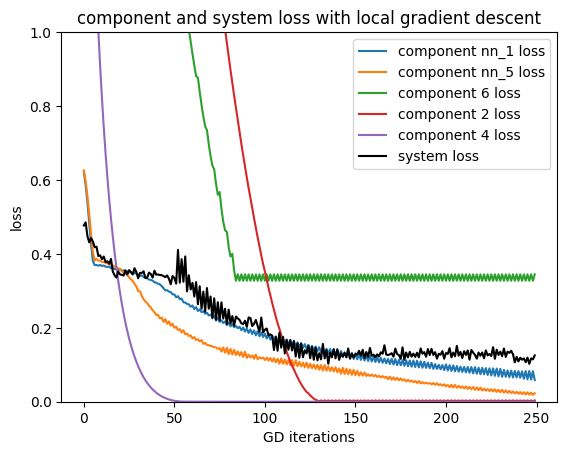

minimum system loss:  tensor(0.1024, dtype=torch.float64)


In [23]:
#grad descent
dg_nn.to_perturb = True
dg_nn.random_initialize_param(grad_descent_starting_seed)
lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=250, plot=True)
lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
print("minimum system loss: ", min(all_loss["system"]))

In [28]:
dg_nn.nodes

NodeView(('nn_1', 'nn_5', 6, 2, 4, 'Blackbox3', 'Blackbox7'))

In [24]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug


vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) >= 3:
        break

    now = time.time()
    dg_nn.random_initialize_param(grad_descent_starting_seed)
    print(dg_nn.get_system_loss())
    for x in range(200):
        dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()
        dg_nn.nodes["nn_5"]["component"].do_one_descent_on_local()
    print(dg_nn.get_system_loss())
    #nx.relabel_nodes(dg_nn, {"nn_1" : "Blackbox_1", "nn_5": "Blackbox_5"}, copy=False)
    all_best_losses, _, _ = BO_graph(dg_nn,printout=True,iteration=200)
    
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)

vanilla_all_trials = np.array(vanilla_all_trials)
np.savetxt("result/mnist_vanilla_100_itr_800_data_seed_99.csv", vanilla_all_trials)

tensor(0.4824, dtype=torch.float64)
tensor(0.4657, dtype=torch.float64)
BO iteration:  0
Current best objective:  -10000
time taken for one BO iteration:  0.3770101070404053
BO iteration:  1
Current best objective:  tensor(-0.4956, dtype=torch.float64)
time taken for one BO iteration:  0.5082039833068848
BO iteration:  2
Current best objective:  tensor(-0.4956, dtype=torch.float64)
time taken for one BO iteration:  0.5563385486602783
BO iteration:  3
Current best objective:  tensor(-0.4956, dtype=torch.float64)
time taken for one BO iteration:  0.6236445903778076
BO iteration:  4
Current best objective:  tensor(-0.2549, dtype=torch.float64)
time taken for one BO iteration:  0.5080265998840332
BO iteration:  5
Current best objective:  tensor(-0.2549, dtype=torch.float64)
time taken for one BO iteration:  0.5463502407073975
BO iteration:  6
Current best objective:  tensor(-0.2549, dtype=torch.float64)
time taken for one BO iteration:  0.44008326530456543
BO iteration:  7
Current best obj

In [ ]:
our_bo_trial = 2
loss_space_bo_all_trials = []
for x in range(200):
    print("number of attempts: ", x)
    print("trial of our BO (successful): ", len(loss_space_bo_all_trials))
    if len(loss_space_bo_all_trials) >= our_bo_trial:
        break
    
    try:
        dg_nn.random_initialize_param(grad_descent_starting_seed)      
        bounds = torch.tensor([np.array(lower_bound_local_loss) * 1, np.array(lower_bound_local_loss) * 5])
        all_best_losses_ours, best_param = BO_graph_local_loss(dg_nn, bounds, "nn_lookup", samples=10, iteration=20)
        loss_space_bo_all_trials.append(all_best_losses_ours)
    except:
        continue
    
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/mnist_our_bo_100_itr_800_data_seed_99.csv", loss_space_bo_all_trials)